# Q1: Gibbs Sampling

Consider a data set on the heights of 695 women and 562 men.
Suppose we have the list of heights, but we don’t know which data
points are from women and which are from men. The data points are available [here](https://drive.google.com/file/d/1_sweLfvqtqdy6oRuAKAG9Le3H-LWaFVK/view?usp=sharing).
The combined distribution of all 1257 heights is shown below.

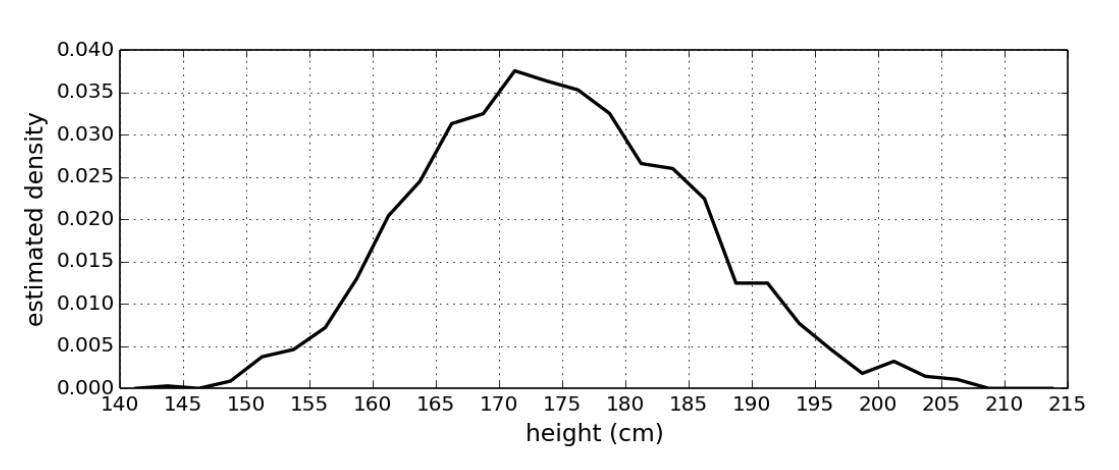

Consider that the combined height distribution is a two-component mixture of Normals, and there is an (essentially) unique set of mixture parameters
corresponding to each particular distribution.

To find individual distributions, let us consider a variable $Z_i$ that
indicates whether the subject i is female or male.
The mixture distribution can be specified as:

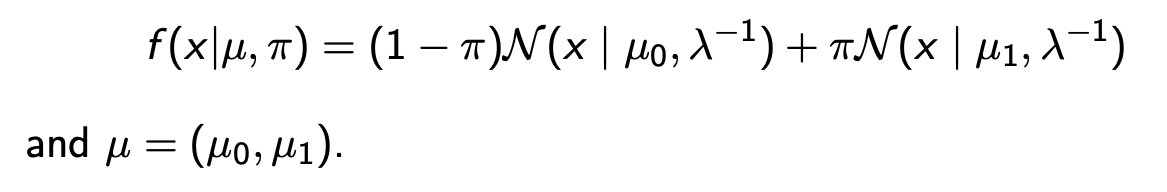

The full conditional distribution i.e. p($x_{1:n}$|µ, π) is a complicated function of µ and π, making the posterior difficult to sample from directly. Hence, we are going to use Gibbs sampling method to make our estimate for the individual components of the height gaussians.

The conditional distributions are specified as:

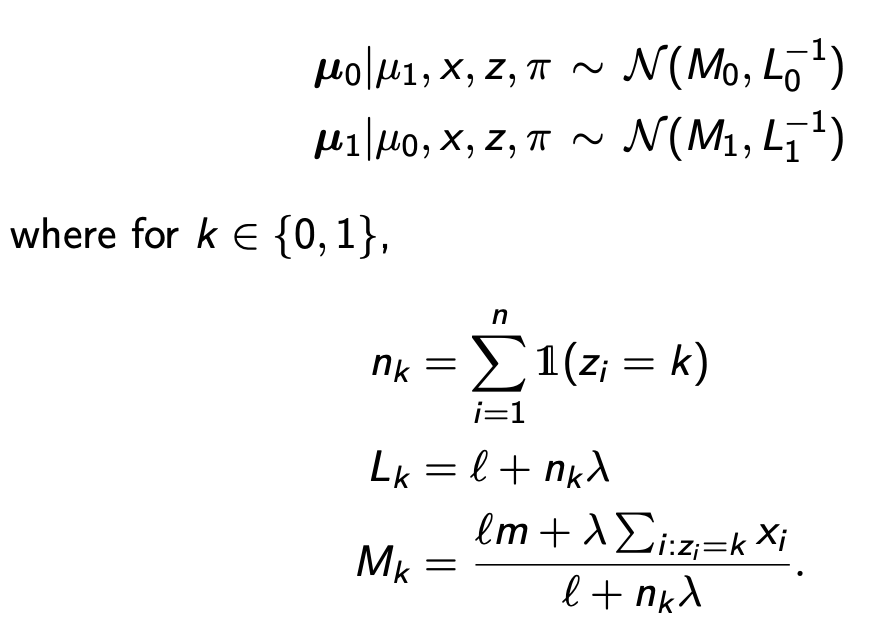

# $p(z|\mu, \pi, x)=$ 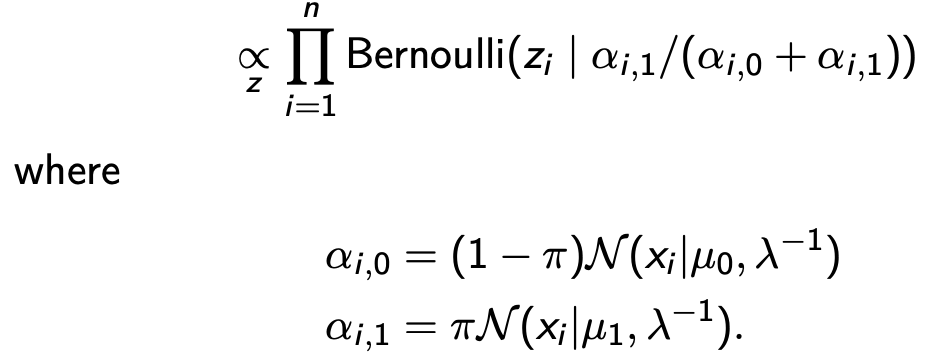

# $\pi = \frac{n_k}{n}$

The complete process can be specified as below:
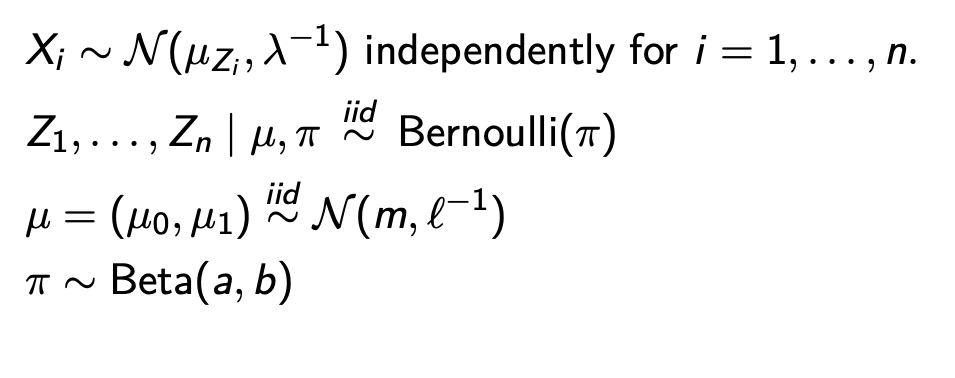

Consider the following initializations:

$\lambda = \frac{1}{\sigma^2}$ where $\sigma = 8$cm.

$m = 175 cm$

$l = \frac{1}{s^2}$ where $s = 15$cm.

a = 1, b = 1 (Beta parameters, equivalent to prior “sample
size” of 1 for each component)

$\pi = 0.5 $

$z_1, . . . , z_n$ are sampled i.i.d. from Bernoulli(1/2) (initial assignment
to components chosen uniformly at random)

$µ_0 = µ_1 = m$ (component means initialized to the mean of
their prior)

Q.1. Use a Gibbs Sampler given the conditionals and initializations provided above and plot the $µ_0, µ_1$ for 1000 samples. [10 marks]

Q.2. Plot the histograms of the heights of subjects assigned to each
component, according to $z_1, . . . , z_n$, in a typical sample after 1000 samples. [10 marks]

Q.3. Plot the $\pi$ for each iterations for both the components. [10 marks]

In [325]:
import csv
import math
import random
import matplotlib.pyplot as plt
import numpy as np

In [326]:
heights = []
with open('Height.csv', 'r') as file:
    csvReader = csv.reader(file)
    next(csvReader)
    heights = [int(row[0]) for row in csvReader for _ in range(int(row[1]))]

In [327]:
def updateMean(x, k, zSamples, priorVariance, priorMean, precision):
    numSamples = np.sum(zSamples == k)
    sumX = np.sum(np.where(zSamples == k, x, 0))
    updatedVariance = priorVariance + numSamples * precision
    updatedMean = (priorVariance * priorMean + precision * sumX) / (priorVariance + numSamples * precision)
    return np.random.normal(updatedMean, 1 / np.sqrt(updatedVariance))

def updatePi(a, b, zSamples):
    return np.random.beta(a=a + sum(1 for sample in zSamples if sample == 1), b=b + sum(1 for sample in zSamples if sample == 0))

def updateAssignments(x, precision, pi, mean0, mean1):
    def calculateNormalPdf(x, mean, std):
        x = np.array(x)
        coefficient = 1 / (math.sqrt(2 * math.pi) * std)
        exponent = -((x - mean) ** 2) / (2 * std ** 2)
        return coefficient * np.exp(exponent)

    alpha0 = (1 - pi) * calculateNormalPdf(x, mean0, 1 / math.sqrt(precision))
    alpha1 = pi * calculateNormalPdf(x, mean1, 1 / math.sqrt(precision))
    return np.random.binomial(1, alpha1 / (alpha0 + alpha1), len(x))

def getData(iterations):
    precision = 1 / (8 ** 2)
    priorMean, priorVariance = 175, 1 / (15 ** 2)
    a, b, pi, mean0, mean1 = 1, 1, 0.5, priorMean, priorMean
    zSamples = np.random.choice([0, 1], size=len(heights))

    for _ in list(range(iterations)):
        gibbs = random.randint(0, 2)

        if gibbs == 0:
            zSamples = updateAssignments(heights, precision, pi, mean0, mean1)
        elif gibbs == 1:
            pi = updatePi(a, b, zSamples)
        else:
            mean0 = updateMean(heights, 0, zSamples, priorVariance, priorMean, precision)
            mean1 = updateMean(heights, 1, zSamples, priorVariance, priorMean, precision)

        pi1Values.append(pi)
        pi2Values.append(1 - pi)
        mean0Values.append(mean0)
        mean1Values.append(mean1)



pi1Values, pi2Values, mean0Values, mean1Values = [], [], [], []
getData(1000)

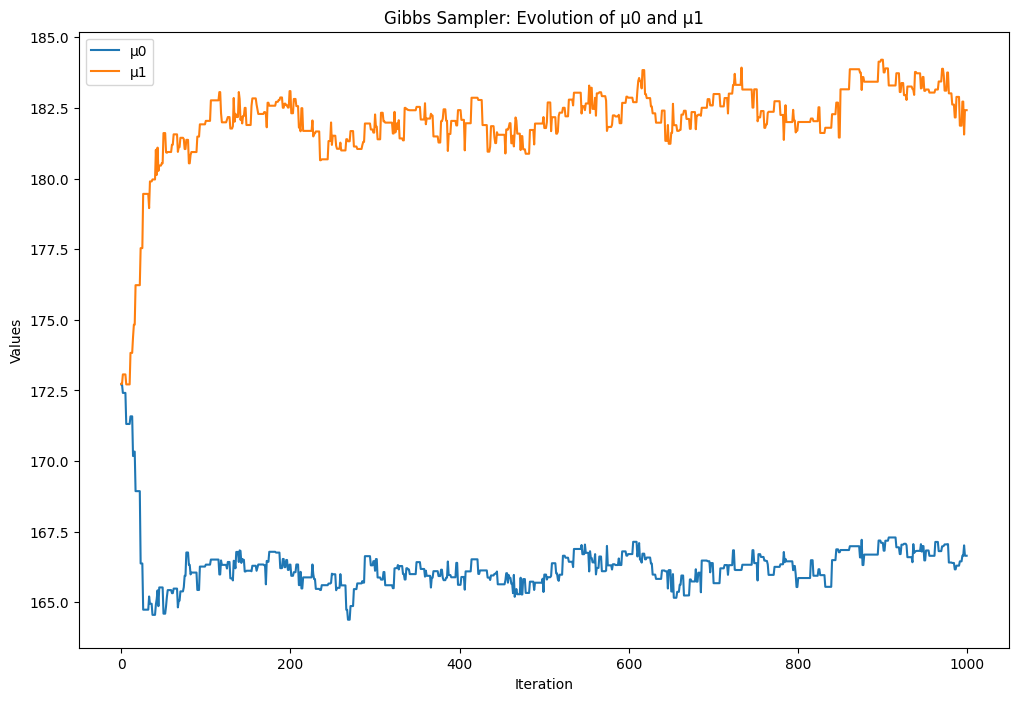

In [328]:
plt.figure(figsize=(12, 8))
plt.plot(mean0Values, label='µ0')
plt.plot(mean1Values, label='µ1')
plt.title('Gibbs Sampler: Evolution of µ0 and µ1')
plt.xlabel('Iteration')
plt.ylabel('Values')
plt.legend()
plt.show()

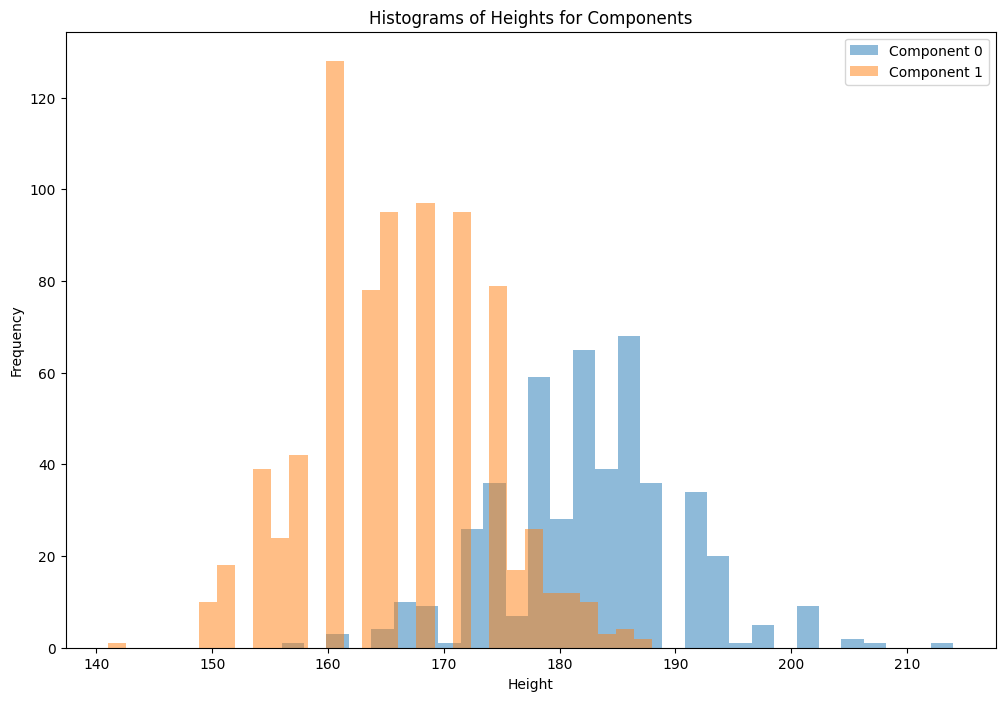

In [329]:
plt.figure(figsize=(12, 8))
plt.hist([heights[i] for i in range(len(zSamples)) if zSamples[i] == 0], bins=30, alpha=0.5, label='Component 0')
plt.hist([heights[i] for i in range(len(zSamples)) if zSamples[i] == 1], bins=30, alpha=0.5, label='Component 1')
plt.title('Histograms of Heights for Components')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()
plt.show()

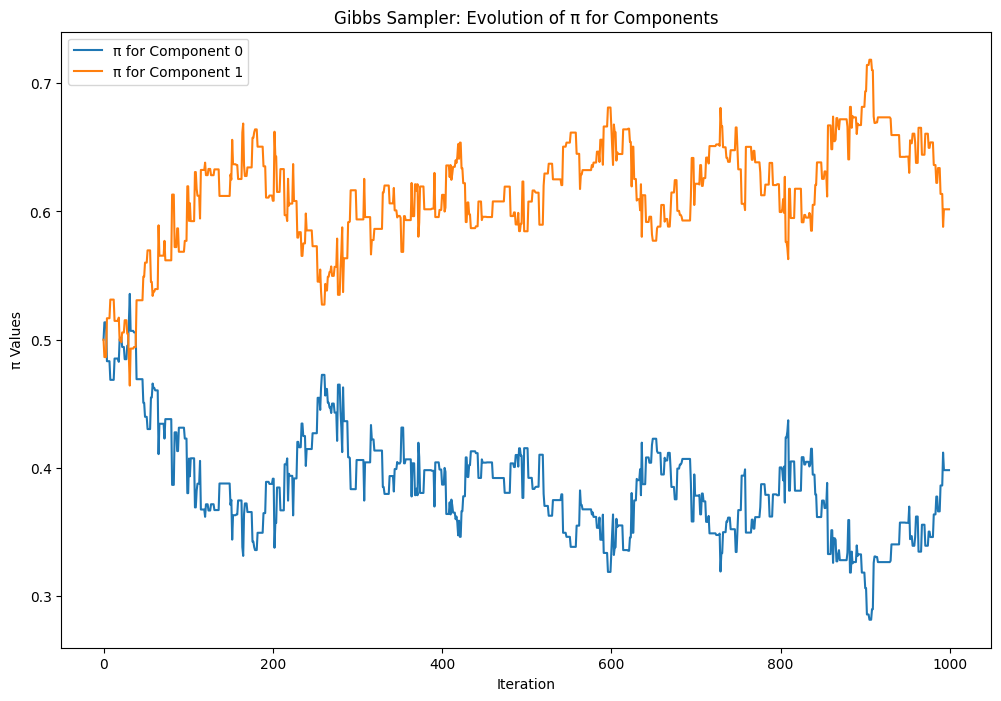

In [330]:
plt.figure(figsize=(12, 8))
plt.plot(pi1Values, label='π for Component 0')
plt.plot(pi2Values, label='π for Component 1')
plt.title('Gibbs Sampler: Evolution of π for Components')
plt.xlabel('Iteration')
plt.ylabel('π Values')
plt.legend()
plt.show()

# Q2: Particle Filter Simulation for Robot Localization

A traveller needs to locate its beloved robot in an unkwown city, but luckly he has a tool that provides the data from the sensors of the robot, but the sensors are not perfect and can provide noisy measurements (the noise information is provided in the code below). Your task is to help the traveller by implementing a Particle Filter algorithm to accurately localize the zone of the robot within the city.


zone = [

    ['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],

    ['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],

    ['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],

    ['2', '2', '2', '4', '4', '4', '4', '8', '8', '8'],

    ['2', '2', '2', '5', '5', '5', '5', '8', '8', '8'],

    ['2', '2', '2', '5', '5', '5', '5', '8', '8', '8'],

    ['2', '2', '2', '5', '5', '5', '5', '9', '9', '9'],

    ['3', '3', '3', '6', '6', '6', '6', '9', '9', '9'],

    ['3', '3', '3', '6', '6', '6', '6', '9', '9', '9'],

    ['3', '3', '3', '6', '6', '6', '6', '9', '9', '9']
]

environment = [

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'W', 'W', 'E', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'W', 'W', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'W', 'E', 'E'],

    ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'W', 'E'],
    
    ['E', 'E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E']
]

In the give environment, 'S' denotes the location of the robot and W denotes walls.




**Transition function**

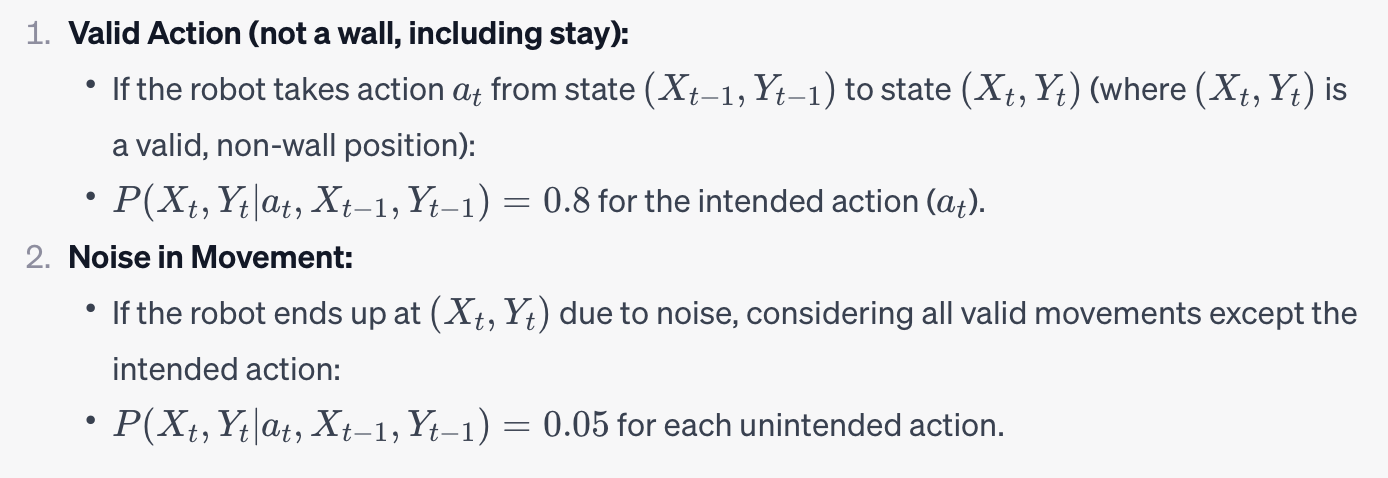

The observation probability P($z_t | x_t, y_t$) represents the probability of the sensor measurement $z_t$ given the true position $x_t, y_t$. The observation probability is 1 indicating that the sensor always detects the true state of the system without any errors, noise, or uncertainty.


**Wrtie a function for the random movement of the robot at each time-step where the action set is {N,S,E,W, stay} where each action is equally likely.**

**[PART 1]** Implement the Particle Filter algorithm (take 5 particles, randomly initialized at empty locations) to localize the robot by estimating its zone after every 10 iterations, till correct zone is located or upto max 100 iterations **[15 marks]**

**Note: Use the 8 neighbouring cells correspoding to the robot and each particle to measure their likehood.**

Example:

Robot (where S denotes the robot)

[E E E]

[W S W]

[E E E]


Particle (where P denotes the particle)

[E E E]

[W P E]

[E E E]

The likelihood of this particle being in the same zone as the robot is 7/8 as their is similarity of 7 neighbouring cells out of 8 based on the sensed infromation.


**[PART 2]** Heatmap: Create a heatmap of the grid where colors represent the probability or weight associated with different cells. Darker colors indicate higher probabilities, providing a visual representation of the confidence in different areas of the grid. **[15 marks]**

In [68]:
zone = [
['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],
['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],
['1', '1', '1', '4', '4', '4', '4', '7', '7', '7'],
['2', '2', '2', '4', '4', '4', '4', '8', '8', '8'],
['2', '2', '2', '5', '5', '5', '5', '8', '8', '8'],
['2', '2', '2', '5', '5', '5', '5', '8', '8', '8'],
['2', '2', '2', '5', '5', '5', '5', '9', '9', '9'],
['3', '3', '3', '6', '6', '6', '6', '9', '9', '9'],
['3', '3', '3', '6', '6', '6', '6', '9', '9', '9'],
['3', '3', '3', '6', '6', '6', '6', '9', '9', '9']
]

environment = [
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'S', 'E', 'E'],
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'],
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'],
['E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E', 'E'],
['E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E', 'E'],
['E', 'E', 'E', 'E', 'E', 'W', 'W', 'E', 'E', 'E'],
['E', 'E', 'E', 'E', 'E', 'E', 'W', 'W', 'E', 'E'],
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'W', 'E', 'E'],
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'W', 'E'],
['E', 'E', 'E', 'E', 'E', 'W', 'E', 'E', 'E', 'E']
]

In [69]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [323]:
def moveAgent(x, y, action):
    if action == 'N' and x > 0:
        x -= 1
    elif action == 'S' and x < len(zone) - 1:
        x += 1
    elif action == 'E' and y < len(zone[0]) - 1:
        y += 1
    elif action == 'W' and y > 0:
        y -= 1
    return x, y

def calculateLikelihood(robotX, robotY, particleX, particleY):
    similarity = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            if 0 <= robotX + i < len(zone) and 0 <= robotY + j < len(zone[0]) and 0 <= particleX + i < len(zone) and 0 <= particleY + j < len(zone[0]):
                if environment[robotX + i][robotY + j] == environment[particleX + i][particleY + j]:
                    similarity += 1
    return similarity / 8

def getRandomAction():
    actions = ['N', 'S', 'E', 'W', 'stay']
    randomAction = random.choice(actions)

    weightedActions, weights = [], []
    for action in actions:
        if action != randomAction:
            weightedActions.append(action)
            weights.append(0.05)
    weightedActions.append(randomAction)
    weights.append(0.8)
    return random.choices(weightedActions, weights=weights)[0]

def particleFilter():
    numParticles, iterations = 5, 100

    particles = []
    for _ in range(numParticles):
        particle = [random.randint(0, len(zone) - 1), random.randint(0, len(zone[0]) - 1)]
        particles.append(particle)

    likelihood = [1] * 5
    robotX, robotY = 0, 7
    for iteration in range(1, iterations + 1):
        action = getRandomAction()
        robotX, robotY = moveAgent(robotX, robotY, action)
        for i, particle in enumerate(particles):
            action = getRandomAction()
            particles[i] = moveAgent(particle[0], particle[1], action)
            likelihood[i] = calculateLikelihood(robotX, robotY, particles[i][0], particles[i][1])

        if iteration % 10 == 0:
            for i, particle in enumerate(particles):
                if zone[robotX][robotY] == zone[particle[0]][particle[1]]:
                    print(f"Robot located at {robotX, robotY}, Zone found in {iteration} iterations!")
                    return

        particles = random.choices(particles, likelihood, k=5)
        print(f"Robot's location after {iteration} iterations: {robotX, robotY}")



seed(7)
particleFilter()

Robot's location after 1 iterations: (0, 7)
Robot's location after 2 iterations: (0, 7)
Robot's location after 3 iterations: (0, 7)
Robot's location after 4 iterations: (0, 7)
Robot's location after 5 iterations: (0, 8)
Robot's location after 6 iterations: (1, 8)
Robot's location after 7 iterations: (1, 9)
Robot's location after 8 iterations: (0, 9)
Robot's location after 9 iterations: (0, 9)
Robot's location after 10 iterations: (0, 9)
Robot's location after 11 iterations: (0, 9)
Robot's location after 12 iterations: (0, 9)
Robot's location after 13 iterations: (0, 9)
Robot's location after 14 iterations: (0, 8)
Robot's location after 15 iterations: (1, 8)
Robot's location after 16 iterations: (1, 9)
Robot's location after 17 iterations: (1, 9)
Robot's location after 18 iterations: (0, 9)
Robot's location after 19 iterations: (1, 9)
Robot's location after 20 iterations: (2, 9)
Robot's location after 21 iterations: (2, 9)
Robot's location after 22 iterations: (3, 9)
Robot's location af

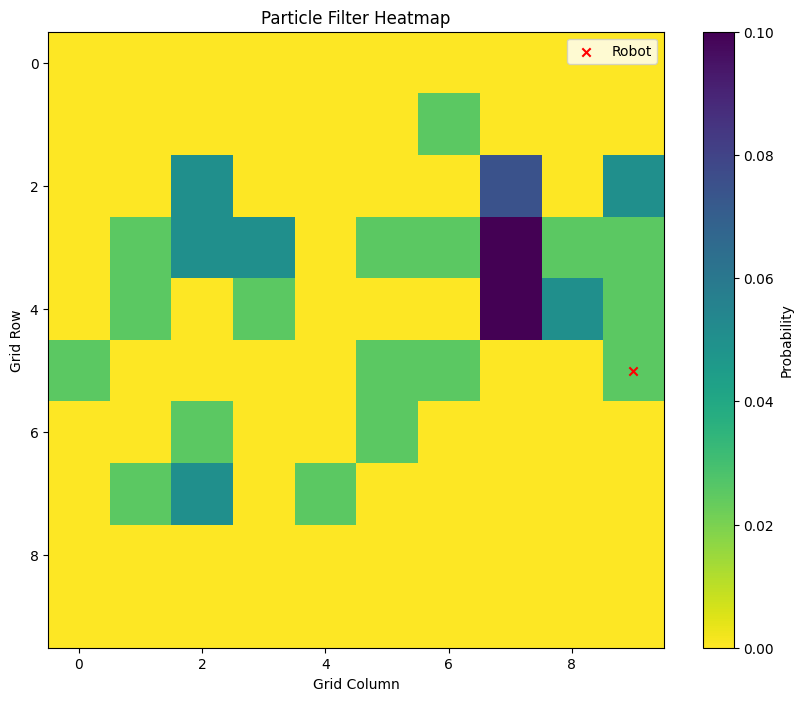

In [324]:
def plotHeatmap(probabilities, robotPosition):
    plt.figure(figsize=(10, 8))
    plt.imshow(probabilities, cmap='viridis_r', interpolation='nearest', origin='upper')
    plt.colorbar(label='Probability')
    plt.scatter(robotPosition[1], robotPosition[0], marker='x', color='red', label='Robot')
    plt.title('Particle Filter Heatmap')
    plt.xlabel('Grid Column')
    plt.ylabel('Grid Row')
    plt.legend()
    plt.show()

def particleFilter():
    numParticles, iterations = 5, 100

    particles = []
    for _ in range(numParticles):
        particle = [random.randint(0, len(zone) - 1), random.randint(0, len(zone[0]) - 1)]
        particles.append(particle)

    likelihood = [1] * 5
    robotX, robotY = 0, 7
    probabilities = np.zeros_like(zone, dtype=float)
    for iteration in range(1, iterations + 1):
        action = getRandomAction()
        robotX, robotY = moveAgent(robotX, robotY, action)
        for i, particle in enumerate(particles):
            action = getRandomAction()
            particles[i] = moveAgent(particle[0], particle[1], action)
            likelihood[i] = calculateLikelihood(robotX, robotY, particles[i][0], particles[i][1])

        if iteration % 10 == 0:
            for i, particle in enumerate(particles):
                probabilities[particle[0], particle[1]] += 1

            for i, particle in enumerate(particles):
                if zone[robotX][robotY] == zone[particle[0]][particle[1]]:
                    probabilities /= np.sum(probabilities)
                    plotHeatmap(probabilities, (robotX, robotY))
                    return

        likelihood /= np.sum(likelihood)
        particles = random.choices(particles, likelihood, k=5)

    probabilities /= np.sum(probabilities)
    plotHeatmap(probabilities, (robotX, robotY))



seed(7)
particleFilter()

# Question 3: X-Men MDP

Most of the X-Men are mutants, a subspecies of humans who are born with superhuman abilities activated by the "X-Gene". The X-Men fight for peace and equality between normal humans and mutants in a world where anti-mutant bigotry is fierce and widespread. They are led by Charles Xavier, also known as Professor X, a powerful mutant telepath who can control and read minds. Their archenemy is Magneto, a powerful mutant with the ability to manipulate and control magnetic fields who leads the Brotherhood of Mutants. Both have opposing views and philosophies regarding the relationship between mutants and humans. While the former works towards peace and understanding between mutants and humans, the latter views humans as a threat and believes in taking an aggressive approach against them.

Jean Grey is one of the most beloved X-Men. But when a mission goes wrong, Jean is exposed to a dark and ancient power. This power has destroyed everything it comes in contact with, until her. Now that this power is becoming unstable, she releases it with destruction and anger. Now that this foreign power is consuming her, and the world is threatened, the X-Men have to face an important truth: they must save either the world, or their friend who threatens it. Magneto calls her ‘The phoenix’ and intends to use her to declare war against humanity.

In this question, you will use some algorithms to compute optimal policies in Markov decision processes (MDP’s) to help wolverine escape from Magneto while trying to find Jean in order to kill her.

You are given the following grid world where Wolverine and other mutants from Xavier's School for Gifted Youngsters live along with Magneto and his brotherhood of mutants.




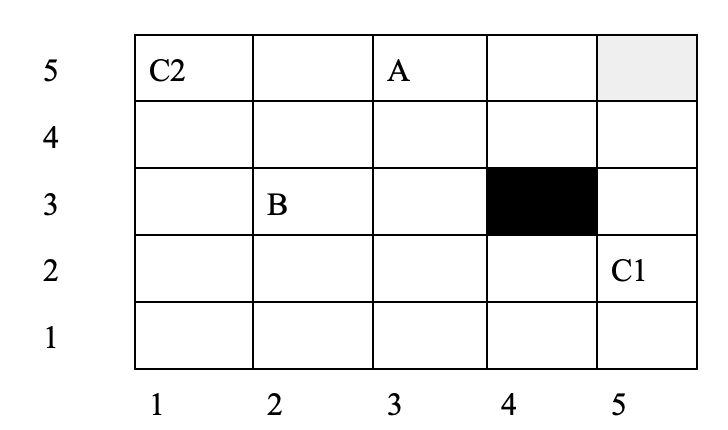

The wolverine (A) can occupy any of the 24 blank squares. The Magneto (B) also can occupy any square, except for square (5,5) which is Xavier’s school of Gifted Youngsters. Jean which can be at C1(5,2) or C2(1,5). Currently, she is at (5,2). Thus, MDP has 24*23*2 = 1104 states.

Wolverine and Magneto can each move one square in any direction - Up,down,left and right but not diagonal. They also can choose not to move at all. (4,3) is blocked due to the wall. Thus, there are 5 possible moves from each square. If an action is attempted that causes the characters(Wolverine and Magneto) to bump into a wall, then simply stay at the same location. In this problem, we will always take the point of view of the wolverine.

Reward Policies:

When Wolverine is at Jean’s place, it receives a reward of +20.
When Magneto is at Wolverine’s place, Wolverine receives a reward of -20.
When the Magneto is at wolverine’s place and wolverine is at jean’s place, the reward is -15.

All other configurations have a reward of 0.
Thus, the wolverine is trying to kill Jean while simultaneously avoiding the Magneto.

Jean is always available in exactly one of the two locations listed above. At every time step, Jean remains where she is with 80% probability. With 20% probability, Jean vanishes and reappears at another location.

States are encoded as six tuples, the first two numbers indicating the position of Magneto, the second two numbers the position of Wolverine, and the last two numbers the position of Jean. Thus, 2:3:3:5:5:2 indicates, as depicted in the figure above, that Magneto is in (2,3), Wolverine is in (3,5), and Jean is in (5,2). Magneto and wolverine take alternate moves. However, in encoding the MDP, we collapse both moves into a single state transition. In addition, Jean, when she moves, does so simultaneously with the wolverine's move. For instance, from the configuration above, if the wolverine moves to (2,5) and the Magneto responds by moving to (2,4), while jean moves to (1,5), this all would be encoded as a single transition from state 2:3:3:5:5:2 to 2:4:2:5:1:5.

The Wolverine and Magneto have 4 actions available ('UP', 'RIGHT', 'DOWN' and 'LEFT'). Each action moves the Wolverine/Magneto in its direction with probability 0.95. When the wolverine tries to move outside of the grid, the action will have no effect with probability 1. Staying in its own state will happen with probability 0.05.

We will consider two versions of Magneto:

In first version, Magneto is dumb and lazy, simply wanders randomly around its environment choosing randomly among its available actions at every step.
In the second version, Magneto is intelligent and active. Here, Magneto always heads straight for wolverine following the shortest path possible. Thus, after wolverine makes its move, Magneto chooses the action that will move it as close as possible to the wolverine's new position. (If there is a tie among the Magneto's best available options, the Magneto chooses randomly among these equally good best actions.)
    
For both versions of Magneto, your job will be to compute the wolverine's optimal policy, i.e. the action that should be taken at each state to maximize the wolverine's expected discounted reward, where we fix the discount factor (gamma) to be 0.85.

**Task 1:** Implement value iteration for both versions of Magneto on MDP [10 points]

**Task 2:** Implement policy iteration for both versions of Magneto [10 points]

**Task 3:** Implement and visualize the MDP board and strategy (policy) graphically [10 points]

**Task 4:** Compare the results for all the four approaches - Value iteration for lazy Magneto, Value iteration for active Magneto, Policy iteration for lazy Magneto, Policy iteration for active Magneto with proper tables/graphs/statistics. Comment which one is best among all the four mentioned approaches. [10 points]



In [189]:
import copy, sys, time, numpy as np, pandas as pd
from itertools import product
from os import name
from random import choice, randint, seed
from tqdm import tqdm

In [191]:
gridSize = 5
discount, movementProbability, jeanMovementProbability = 0.85, 0.95, 0.2
blockedCell, xavierSchoolCell, jeanCells = (4, 3), (5, 5), [(5, 2), (1, 5)]
moves = [(1, 0), (0, 1), (0, -1), (-1, 0)]

In [197]:
class Jean(object):
    def __init__(self, possibleCells, movementProbability):
        self.possibleCells, self.movementProbability = possibleCells, movementProbability
        self.positionIndex = randint(0, len(possibleCells) - 1)

    def move(self):
        if randint(1, 100) <= (self.movementProbability * 100):
            self.positionIndex = 1 - self.positionIndex
        return self.currentPosition()

    def currentPosition(self):
        return self.possibleCells[self.positionIndex]


class LazyMagneto(object):
    def __init__(self, gridSize, moves, blockedCells, movementProbability):
        self.gridSize, self.moves, self.blockedCells, self.movementProbability = gridSize, moves, blockedCells, movementProbability
        self.positionIndex = (randint(1, gridSize), randint(1, gridSize))

        while self.isValid(self.positionIndex) != True:
            self.positionIndex = (randint(1, gridSize), randint(1, gridSize))

    def isValid(self, nextCell):
        if nextCell[0] > 0 and nextCell[1] > 0 and nextCell[0] < (self.gridSize + 1) and  nextCell[1] < (self.gridSize + 1) and nextCell not in self.blockedCells:
            return True
        return False

    def move(self, wolverineCell):
        while True:
            nextMove = self.moves[randint(0, len(self.moves) - 1)]
            nextCell = tuple(map(lambda i, j: i + j, nextMove, self.positionIndex))
            if self.isValid(nextCell) == True:
                break

        if randint(1, 100) <= (self.movementProbability * 100):
            self.positionIndex = nextCell
        return self.currentPosition()

    def currentPosition(self):
        return self.positionIndex


class ActiveMagneto(object):
    def __init__(self, gridSize, moves, blockedCells, movementProbability):
        self.gridSize, self.moves, self.blockedCells, self.movementProbability = gridSize, moves, blockedCells, movementProbability
        self.positionIndex = (randint(1, gridSize), randint(1, gridSize))
        while self.isValid(self.positionIndex) != True:
            self.positionIndex = (randint(1, gridSize), randint(1, gridSize))

    def isValid(self, nextCell):
        if nextCell[0] > 0 and nextCell[1] > 0 and nextCell[0] < (self.gridSize + 1) and  nextCell[1] < (self.gridSize + 1) and nextCell not in self.blockedCells:
            return True
        return False

    def move(self, wolverineCell):
        startingCell = self.positionIndex
        distances = [self.findWolverine((startingCell[0] + move[0], startingCell[1] + move[1]), wolverineCell)
                     if self.isValid((startingCell[0] + move[0], startingCell[1] + move[1])) else 1000
                     for move in moves]
        nextCell = moves[choice([i for i, d in enumerate(distances) if d == min(distances)])]
        if randint(1, 100) <= (self.movementProbability * 100):
            self.positionIndex = (nextCell[0] + self.positionIndex[0], nextCell[1] + self.positionIndex[1])
        return self.positionIndex

    def findWolverine(self, magnetoCell, wolverineCell):
        startingCell, endingCell = magnetoCell, wolverineCell
        visited = np.zeros((self.gridSize, self.gridSize), dtype=np.uint8)
        visited[tuple(map(lambda x: x - 1, blockedCell))] = 1
        visited[tuple(map(lambda x: x - 1, startingCell))] = 1

        queue = [[*startingCell, 0]]
        while queue:
            front = queue.pop(0)
            if (front[0], front[1]) == endingCell:
                return front[2]

            for move in self.moves:
                nextCell = (front[0] + move[0], front[1] + move[1])
                if 0 < nextCell[0] <= self.gridSize and 0 < nextCell[1] <= self.gridSize and not visited[tuple(map(lambda x: x - 1, nextCell))]:
                    queue.append([*nextCell, front[2] + 1])
                    visited[tuple(map(lambda x: x - 1, nextCell))] = 1

    def currentPosition(self):
        return self.positionIndex

In [198]:
def playGame(mdp, magneto):
    iterations, jean = 1000000, Jean(jeanCells, jeanMovementProbability)
    magnetoCell, wolverineCell, jeanCell = magneto.currentPosition(), (randint(1, 5), randint(1, 5)), jean.currentPosition()
    while not isValidWolverine(wolverineCell):
        wolverineCell = (randint(1, gridSize), randint(1, gridSize))

    print("INITIAL BOARD")
    drawBoard(magnetoCell, wolverineCell, jeanCell)
    result = getWinner(magnetoCell, wolverineCell, jeanCell)
    for i in range(iterations):
        result = getWinner(magnetoCell, wolverineCell, jeanCell)
        if result is not None:
            break

        magnetoNextCell, jeanNextCell =  magneto.move(wolverineCell), jean.move()
        result = getWinner(magnetoNextCell, wolverineCell, jeanNextCell)
        if result is not None:
            drawBoard(magnetoNextCell, wolverineCell, jeanNextCell)
            break

        nextMove = mdp.nextMove(magnetoCell, wolverineCell, jeanCell)
        if nextMove is not None and randint(1, 100) <= (movementProbability * 100):
            wolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, nextMove))

        print(f"\nBOARD AFTER {i + 1} MOVE(S)")
        jeanCell, magnetoCell = jean.currentPosition(), magneto.currentPosition()
        drawBoard(magnetoCell, wolverineCell, jeanCell)

    print("MAGNETO IS VICTORIOUS!" if result == -1 else
          "DRAW!" if result == 0 else
          "WOLVERINE IS VICTORIOUS!" if result == 1 else
          "ITERATION LIMIT EXCEEDED!")

def getWinner(magnetoCell, wolverineCell, jeanCell):
    if jeanCell != magnetoCell and magnetoCell == wolverineCell:
        return -1
    elif jeanCell == magnetoCell == wolverineCell:
        return 0
    elif jeanCell == wolverineCell and wolverineCell != magnetoCell:
        return 1
    return None

def drawBoard(magnetoCell, wolverineCell, jeanCell):
    print(f"Jean: {jeanCell}")
    print(f"Magneto: {magnetoCell}")
    print(f"Wolverine: {wolverineCell}\n")

    grid = [['0' for _ in range(gridSize)] for _ in range(gridSize)]
    def placeCharacter(cell, character):
        grid[cell[1] - 1][cell[0] - 1] = character

    placeCharacter(jeanCell, 'J')
    placeCharacter(wolverineCell, 'W')
    placeCharacter(magnetoCell, 'M')
    placeCharacter(blockedCell, 'B')
    placeCharacter(xavierSchoolCell, 'X')

    for row in grid[::-1]:
        print(' '.join(row))
    print()

In [194]:
def isValidWolverine(nextCell):
    blockedCells = [blockedCell]
    if nextCell[0] > 0 and nextCell[1] > 0 and nextCell[0] < (gridSize + 1) and  nextCell[1] < (gridSize + 1) and nextCell not in blockedCells:
        return True
    return False

def nextMagnetoMove(magnetoCell, wolverineCell):
    startingCell = magnetoCell
    distances = [findWolverine((startingCell[0] + move[0], startingCell[1] + move[1]), wolverineCell)
                  if isValidMagneto((startingCell[0] + move[0], startingCell[1] + move[1])) else 1000
                  for move in moves]
    return [moves[j] for j in [i for i, d in enumerate(distances) if d == min(distances)]]

def findWolverine(magnetoCell, wolverineCell):
    startingCell, endingCell = magnetoCell, wolverineCell
    visited = np.zeros((gridSize, gridSize), dtype=np.uint8)
    visited[tuple(map(lambda x: x - 1, blockedCell))] = 1
    visited[tuple(map(lambda x: x - 1, startingCell))] = 1

    queue = [[*startingCell, 0]]
    while queue:
        front = queue.pop(0)
        if (front[0], front[1]) == endingCell:
            return front[2]

        for move in moves:
            nextCell = (front[0] + move[0], front[1] + move[1])
            if 0 < nextCell[0] <= gridSize and 0 < nextCell[1] <= gridSize and not visited[tuple(map(lambda x: x - 1, nextCell))]:
                queue.append([*nextCell, front[2] + 1])
                visited[tuple(map(lambda x: x - 1, nextCell))] = 1

def isValidMagneto(nextCell):
    blockedCells = [blockedCell, xavierSchoolCell]
    if nextCell[0] > 0 and nextCell[1] > 0 and nextCell[0] < (gridSize + 1) and  nextCell[1] < (gridSize + 1) and nextCell not in blockedCells:
        return True
    return False

In [206]:
class MDPValue():
    def __init__(self, gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, limit):
        self.gridSize, self.moves, self.blockedCell, self.xavierSchoolCell, self.jeanCells = gridSize, moves, blockedCell, xavierSchoolCell, jeanCells
        self.discount, self.movementProbability, self.jeanMovementProbability, self.limit = discount, movementProbability, jeanMovementProbability, limit
        self.states, self.policy, self.endState = {}, {}, {}

        for (magnetoX, magnetoY), (wolverineX, wolverineY) in product(product(range(1, gridSize + 1), repeat=2), repeat=2):
            if (magnetoX, magnetoY) == xavierSchoolCell or (magnetoX, magnetoY) == blockedCell or (wolverineX, wolverineY) == blockedCell:
                continue

            for jeanCell in self.jeanCells:
                key = (magnetoX, magnetoY, wolverineX, wolverineY) + jeanCell
                self.states[key] = (
                    20 if key[4:] == (wolverineX, wolverineY) and key[:4] != (magnetoX, magnetoY) else
                    -15 if key[4:] == (wolverineX, wolverineY) and key[:4] == (magnetoX, magnetoY) else
                    -20 if key[4:] != (wolverineX, wolverineY) and key[:4] == (magnetoX, magnetoY) else
                    0
                )
                self.endState[key] = 1 if key[4:] == (wolverineX, wolverineY) else 0

    def train(self):
        pass

    def isValid(self, nextCell, blockedCells):
        return 0 < nextCell[0] <= self.gridSize and 0 < nextCell[1] <= self.gridSize and nextCell not in blockedCells

    def nextMove(self, magnetoCell, wolverineCell, jeanCell):
        return self.policy[magnetoCell + wolverineCell + jeanCell]

In [207]:
class MDPValueLazy(MDPValue):
    def train(self):
        print("Training model...")
        iterations = 100000
        for _ in tqdm(range(iterations)):
            converged = True
            newStates, newPolicy = {}, {}

            for key in self.states.keys():
                if self.endState[key] == 1:
                    newStates[key], newPolicy[key] = self.states[key], None
                    continue

                possibleStates, possibleActions = [], []
                magnetoCell, wolverineCell, jeanCell = key[:2], key[2:4], key[4:]
                validMagnetoActions = sum(self.isValid(tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction)),
                                                    [self.blockedCell, self.xavierSchoolCell]) for magnetoAction in self.moves)

                for action in self.moves:
                    nextWolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, action))
                    if self.isValid(nextWolverineCell, [self.blockedCell]):
                        for magnetoAction in self.moves:
                            transitionProbability = self.movementProbability * self.movementProbability / validMagnetoActions
                            for jeanAction in self.jeanCells:
                                nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))
                                if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                                    transitionProbability *= self.jeanMovementProbability
                                    nextState = nextMagnetoCell + nextWolverineCell + jeanAction
                                    if jeanCell == jeanAction:
                                        transitionProbability *= (1 - self.jeanMovementProbability)
                                        nextState = nextMagnetoCell + nextWolverineCell + jeanCell

                                    possibleStates.append(transitionProbability * (
                                            self.states[nextState] + 0 if self.endState[nextState] else
                                            self.states[nextState] * self.discount)
                                    )
                                    possibleActions.append(action)

                        for magnetoAction in self.moves:
                            transitionProbability = self.movementProbability * (1 - self.movementProbability) / validMagnetoActions
                            for jeanAction in self.jeanCells:
                                nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))
                                if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                                    transitionProbability *= self.jeanMovementProbability
                                    nextState = nextMagnetoCell + wolverineCell + jeanAction
                                    if jeanCell == jeanAction:
                                        transitionProbability *= (1 - self.jeanMovementProbability)
                                        nextState = nextMagnetoCell + wolverineCell + jeanCell

                                    possibleStates.append(transitionProbability * (
                                            self.states[nextState] + 0 if self.endState[nextState] else
                                            self.states[nextState] * self.discount)
                                    )
                                    possibleActions.append(action)

                newStates[key] = max(possibleStates)
                newPolicy[key] = possibleActions[possibleStates.index(max(possibleStates))]

            for key in self.states.keys():
                if abs(newStates[key] - self.states[key]) > self.limit:
                    converged = False

            if converged:
                print("\n\nModel converged!\n\n\n")
                break
            self.states, self.policy = copy.deepcopy(newStates), copy.deepcopy(newPolicy)



seed(0)
mdp = MDPValueLazy(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
mdp.train()
playGame(mdp, LazyMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability))

Training model...


  0%|          | 2/100000 [00:00<10:30:42,  2.64it/s]



Model converged!



INITIAL BOARD
Jean: (5, 2)
Magneto: (4, 4)
Wolverine: (3, 5)

0 0 W 0 X
0 0 0 M 0
0 0 0 B 0
0 0 0 0 J
0 0 0 0 0


BOARD AFTER 1 MOVE(S)
Jean: (5, 2)
Magneto: (3, 4)
Wolverine: (2, 5)

0 W 0 0 X
0 0 M 0 0
0 0 0 B 0
0 0 0 0 J
0 0 0 0 0


BOARD AFTER 2 MOVE(S)
Jean: (5, 2)
Magneto: (3, 3)
Wolverine: (1, 5)

W 0 0 0 X
0 0 0 0 0
0 0 M B 0
0 0 0 0 J
0 0 0 0 0

Jean: (1, 5)
Magneto: (3, 4)
Wolverine: (1, 5)

W 0 0 0 X
0 0 M 0 0
0 0 0 B 0
0 0 0 0 0
0 0 0 0 0

WOLVERINE IS VICTORIOUS!


In [208]:
class MDPValueActive(MDPValue):
    def train(self):
        print("Training model...")
        iterations = 100000
        for _ in tqdm(range(iterations)):
            converged = True
            newStates, newPolicy = {}, {}

            for key in self.states.keys():
                if self.endState[key] == 1:
                    newStates[key], newPolicy[key] = self.states[key], None
                    continue

                possibleStates, possibleActions = [], []
                magnetoCell, wolverineCell, jeanCell = key[:2], key[2:4], key[4:]
                magnetoMoves = nextMagnetoMove(magnetoCell, wolverineCell)
                validMagnetoActions = len(magnetoMoves)

                for action in self.moves:
                    nextWolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, action))
                    if self.isValid(nextWolverineCell, [self.blockedCell]):
                        for magnetoAction in magnetoMoves:
                            transitionProbability = self.movementProbability * self.movementProbability / validMagnetoActions
                            for jeanAction in self.jeanCells:
                                nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))
                                if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                                    transitionProbability *= self.jeanMovementProbability
                                    nextState = nextMagnetoCell + nextWolverineCell + jeanAction
                                    if jeanCell == jeanAction:
                                        transitionProbability *= (1 - self.jeanMovementProbability)
                                        nextState = nextMagnetoCell + nextWolverineCell + jeanCell

                                    possibleStates.append(transitionProbability * (
                                            self.states[nextState] + 0 if self.endState[nextState] else
                                            self.states[nextState] * self.discount)
                                    )
                                    possibleActions.append(action)

                        magnetoMoves = nextMagnetoMove(magnetoCell, wolverineCell)
                        validMagnetoActions = len(magnetoMoves)
                        for magnetoAction in self.moves:
                            transitionProbability = self.movementProbability * (1 - self.movementProbability) / validMagnetoActions
                            for jeanAction in self.jeanCells:
                                nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))
                                if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                                    transitionProbability *= self.jeanMovementProbability
                                    nextState = nextMagnetoCell + wolverineCell + jeanAction
                                    if jeanCell == jeanAction:
                                        transitionProbability *= (1 - self.jeanMovementProbability)
                                        nextState = nextMagnetoCell + wolverineCell + jeanCell

                                    possibleStates.append(transitionProbability * (
                                            self.states[nextState] + 0 if self.endState[nextState] else
                                            self.states[nextState] * self.discount)
                                    )
                                    possibleActions.append(action)

                newStates[key] = max(possibleStates)
                newPolicy[key] = possibleActions[possibleStates.index(max(possibleStates))]

            for key in self.states.keys():
                if abs(newStates[key] - self.states[key]) > self.limit:
                    converged = False

            if converged:
                print("\n\nModel converged!\n\n\n")
                break
            self.states, self.policy = copy.deepcopy(newStates), copy.deepcopy(newPolicy)



seed(1)
mdp = MDPValueActive(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
mdp.train()
playGame(mdp, ActiveMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability))

Training model...


  0%|          | 2/100000 [00:02<40:29:24,  1.46s/it]



Model converged!



INITIAL BOARD
Jean: (5, 2)
Magneto: (2, 5)
Wolverine: (3, 1)

0 M 0 0 X
0 0 0 0 0
0 0 0 B 0
0 0 0 0 J
0 0 W 0 0


BOARD AFTER 1 MOVE(S)
Jean: (5, 2)
Magneto: (2, 5)
Wolverine: (4, 1)

0 M 0 0 X
0 0 0 0 0
0 0 0 B 0
0 0 0 0 J
0 0 0 W 0


BOARD AFTER 2 MOVE(S)
Jean: (1, 5)
Magneto: (2, 4)
Wolverine: (4, 2)

J 0 0 0 X
0 M 0 0 0
0 0 0 B 0
0 0 0 W 0
0 0 0 0 0


BOARD AFTER 3 MOVE(S)
Jean: (1, 5)
Magneto: (3, 4)
Wolverine: (5, 2)

J 0 0 0 X
0 0 M 0 0
0 0 0 B 0
0 0 0 0 W
0 0 0 0 0


BOARD AFTER 4 MOVE(S)
Jean: (1, 5)
Magneto: (4, 4)
Wolverine: (5, 3)

J 0 0 0 X
0 0 0 M 0
0 0 0 B W
0 0 0 0 0
0 0 0 0 0


BOARD AFTER 5 MOVE(S)
Jean: (5, 2)
Magneto: (5, 4)
Wolverine: (5, 2)

0 0 0 0 X
0 0 0 0 M
0 0 0 B 0
0 0 0 0 W
0 0 0 0 0

WOLVERINE IS VICTORIOUS!


In [209]:
class MDPPolicy():
    def __init__(self, gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, limit):
        self.gridSize, self.moves, self.blockedCell, self.xavierSchoolCell, self.jeanCells = gridSize, moves, blockedCell, xavierSchoolCell, jeanCells
        self.discount, self.movementProbability, self.jeanMovementProbability, self.limit = discount, movementProbability, jeanMovementProbability, limit
        self.states, self.policy, self.endState = {}, {}, {}

        for (magnetoX, magnetoY), (wolverineX, wolverineY) in product(product(range(1, gridSize + 1), repeat=2), repeat=2):
            if (magnetoX, magnetoY) == xavierSchoolCell or (magnetoX, magnetoY) == blockedCell or (wolverineX, wolverineY) == blockedCell:
                continue

            for jeanCell in self.jeanCells:
                key = (magnetoX, magnetoY, wolverineX, wolverineY) + jeanCell
                self.states[key] = (
                    20 if key[4:] == (wolverineX, wolverineY) and key[:4] != (magnetoX, magnetoY) else
                    -15 if key[4:] == (wolverineX, wolverineY) and key[:4] == (magnetoX, magnetoY) else
                    -20 if key[4:] != (wolverineX, wolverineY) and key[:4] == (magnetoX, magnetoY) else
                    0
                )
                self.endState[key] = 1 if key[4:] == (wolverineX, wolverineY) else 0

        for key in self.states.keys():
            if self.endState[key] != 1:
                self.policy[key] = choice(self.moves)
            else:
                self.policy[key] = (0, 0)

    def policyIteration(self):
        print("Policy Iteration...")
        policyStable = False
        for _ in tqdm(range(100000)):
            self.policyEvaluation()
            policyStable = self.policyImprovement()
            if policyStable == True:
                print("\n\nPolicy Converged!\n\n")
                break

    def isValid(self, nextCell, blockedCells):
        return 0 < nextCell[0] <= self.gridSize and 0 < nextCell[1] <= self.gridSize and nextCell not in blockedCells

    def nextMove(self, magnetoCell, wolverineCell, jeanCell):
        return self.policy[magnetoCell + wolverineCell + jeanCell]

In [210]:
class MDPPolicyLazy(MDPPolicy):
    def policyEvaluation(self):
        converged = False
        while not converged:
            delta = 0
            for key in self.states.keys():
                if self.endState[key] == 1:
                    continue

                magnetoCell, wolverineCell, jeanCell = key[:2], key[2:4], key[4:]
                action = self.policy[key]
                nextWolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, action))

                if self.isValid(nextWolverineCell, [self.blockedCell]):
                    expectedReward = 0
                    for magnetoAction in self.moves:
                        transitionProbability = self.movementProbability * self.movementProbability
                        nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))

                        if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                            for jeanAction in self.jeanCells:
                                transitionProbability *= self.jeanMovementProbability
                                nextState = nextMagnetoCell + nextWolverineCell + jeanAction

                                if jeanCell == jeanAction:
                                    transitionProbability *= (1 - self.jeanMovementProbability)
                                    nextState = nextMagnetoCell + nextWolverineCell + jeanCell

                                expectedReward += transitionProbability * (
                                        self.states[nextState] + 0 if self.endState[nextState] else
                                        self.states[nextState] * self.discount
                                )

                    delta = max(delta, abs(expectedReward - self.states[key]))
                    self.states[key] = expectedReward

            if delta < self.limit:
                converged = True

    def policyImprovement(self):
        policyStable = True
        for key in self.states.keys():
            if self.endState[key] == 1:
                continue

            magnetoCell, wolverineCell, jeanCell = key[:2], key[2:4], key[4:]
            bestAction, bestValue = None, float('-inf')

            for action in self.moves:
                nextWolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, action))

                if self.isValid(nextWolverineCell, [self.blockedCell]):
                    expectedReward = 0
                    for magnetoAction in self.moves:
                        transitionProbability = self.movementProbability * self.movementProbability
                        nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))

                        if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                            for jeanAction in self.jeanCells:
                                transitionProbability *= self.jeanMovementProbability
                                nextState = nextMagnetoCell + nextWolverineCell + jeanAction

                                if jeanCell == jeanAction:
                                    transitionProbability *= (1 - self.jeanMovementProbability)
                                    nextState = nextMagnetoCell + nextWolverineCell + jeanCell

                                expectedReward += transitionProbability * (
                                        self.states[nextState] + 0 if self.endState[nextState] else
                                        self.states[nextState] * self.discount
                                )

                    if expectedReward > bestValue:
                        bestValue = expectedReward
                        bestAction = action

            if bestAction != self.policy[key]:
                policyStable = False
                self.policy[key] = bestAction

        return policyStable



seed(0)
mdp = MDPPolicyLazy(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
mdp.policyIteration()
playGame(mdp, LazyMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability))

Policy Iteration...


  0%|          | 3/100000 [00:00<8:30:28,  3.26it/s]



Policy Converged!


INITIAL BOARD
Jean: (5, 2)
Magneto: (5, 2)
Wolverine: (3, 4)

0 0 0 0 X
0 0 W 0 0
0 0 0 B 0
0 0 0 0 M
0 0 0 0 0


BOARD AFTER 1 MOVE(S)
Jean: (5, 2)
Magneto: (5, 3)
Wolverine: (4, 4)

0 0 0 0 X
0 0 0 W 0
0 0 0 B M
0 0 0 0 J
0 0 0 0 0


BOARD AFTER 2 MOVE(S)
Jean: (5, 2)
Magneto: (5, 3)
Wolverine: (5, 4)

0 0 0 0 X
0 0 0 0 W
0 0 0 B M
0 0 0 0 J
0 0 0 0 0


BOARD AFTER 3 MOVE(S)
Jean: (5, 2)
Magneto: (5, 3)
Wolverine: (5, 3)

0 0 0 0 X
0 0 0 0 0
0 0 0 B M
0 0 0 0 J
0 0 0 0 0

MAGNETO IS VICTORIOUS!


In [243]:
class MDPPolicyActive(MDPPolicy):
    def policyEvaluation(self):
        converged = False
        while not converged:
            delta = 0
            for key in self.states.keys():
                if self.endState[key] == 1:
                    continue

                magnetoCell, wolverineCell, jeanCell = key[:2], key[2:4], key[4:]
                action = self.policy[key]
                nextWolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, action))

                if self.isValid(nextWolverineCell, [self.blockedCell]):
                    expectedReward = 0
                    for magnetoAction in nextMagnetoMove(magnetoCell, wolverineCell):
                        transitionProbability = self.movementProbability * self.movementProbability
                        nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))

                        if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                            for jeanAction in self.jeanCells:
                                transitionProbability *= self.jeanMovementProbability
                                nextState = nextMagnetoCell + nextWolverineCell + jeanAction

                                if jeanCell == jeanAction:
                                    transitionProbability *= (1 - self.jeanMovementProbability)
                                    nextState = nextMagnetoCell + nextWolverineCell + jeanCell

                                expectedReward += transitionProbability * (
                                        self.states[nextState] + 0 if self.endState[nextState] else
                                        self.states[nextState] * self.discount
                                )

                    delta = max(delta, abs(expectedReward - self.states[key]))
                    self.states[key] = expectedReward

            if delta < self.limit:
                converged = True

    def policyImprovement(self):
        policyStable = True
        for key in self.states.keys():
            if self.endState[key] == 1:
                continue

            magnetoCell, wolverineCell, jeanCell = key[:2], key[2:4], key[4:]
            bestAction, bestValue = None, float('-inf')

            for action in self.moves:
                nextWolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, action))

                if self.isValid(nextWolverineCell, [self.blockedCell]):
                    expectedReward = 0
                    for magnetoAction in nextMagnetoMove(magnetoCell, wolverineCell):
                        transitionProbability = self.movementProbability * self.movementProbability
                        nextMagnetoCell = tuple(map(lambda i, j: i + j, magnetoCell, magnetoAction))

                        if self.isValid(nextMagnetoCell, [self.blockedCell, self.xavierSchoolCell]):
                            for jeanAction in self.jeanCells:
                                transitionProbability *= self.jeanMovementProbability
                                nextState = nextMagnetoCell + nextWolverineCell + jeanAction

                                if jeanCell == jeanAction:
                                    transitionProbability *= (1 - self.jeanMovementProbability)
                                    nextState = nextMagnetoCell + nextWolverineCell + jeanCell

                                expectedReward += transitionProbability * (
                                        self.states[nextState] + 0 if self.endState[nextState] else
                                        self.states[nextState] * self.discount
                                )

                    if expectedReward > bestValue:
                        bestValue = expectedReward
                        bestAction = action

            if bestAction != self.policy[key]:
                policyStable = False
                self.policy[key] = bestAction

        return policyStable



seed(0)
mdp = MDPPolicyActive(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
mdp.policyIteration()
playGame(mdp, ActiveMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability))

Policy Iteration...


  0%|          | 4/100000 [00:06<44:39:23,  1.61s/it]



Policy Converged!


INITIAL BOARD
Jean: (5, 2)
Magneto: (5, 2)
Wolverine: (3, 4)

0 0 0 0 X
0 0 W 0 0
0 0 0 B 0
0 0 0 0 M
0 0 0 0 0


BOARD AFTER 1 MOVE(S)
Jean: (5, 2)
Magneto: (5, 3)
Wolverine: (3, 3)

0 0 0 0 X
0 0 0 0 0
0 0 W B M
0 0 0 0 J
0 0 0 0 0


BOARD AFTER 2 MOVE(S)
Jean: (5, 2)
Magneto: (5, 4)
Wolverine: (3, 3)

0 0 0 0 X
0 0 0 0 M
0 0 W B 0
0 0 0 0 J
0 0 0 0 0


BOARD AFTER 3 MOVE(S)
Jean: (5, 2)
Magneto: (4, 4)
Wolverine: (3, 2)

0 0 0 0 X
0 0 0 M 0
0 0 0 B 0
0 0 W 0 J
0 0 0 0 0


BOARD AFTER 4 MOVE(S)
Jean: (5, 2)
Magneto: (4, 4)
Wolverine: (4, 2)

0 0 0 0 X
0 0 0 M 0
0 0 0 B 0
0 0 0 W J
0 0 0 0 0


BOARD AFTER 5 MOVE(S)
Jean: (5, 2)
Magneto: (5, 4)
Wolverine: (5, 2)

0 0 0 0 X
0 0 0 0 M
0 0 0 B 0
0 0 0 0 W
0 0 0 0 0

WOLVERINE IS VICTORIOUS!


In [212]:
def plotGameState(magnetoCell, wolverineCell, jeanCell, gridSize, policy=None):
    fig, ax = plt.subplots()
    for i in range(gridSize + 1):
        ax.plot([0, gridSize], [i, i], color='black', linestyle='-', linewidth=1)
        ax.plot([i, i], [0, gridSize], color='black', linestyle='-', linewidth=1)

    ax.text(*wolverineCell, 'WO', color='blue', ha='center', va='center', fontsize=12, fontweight=1000)
    ax.text(*magnetoCell, 'MA', color='red', ha='center', va='center', fontsize=12, fontweight=1000)
    ax.text(*jeanCell, 'JE', color='green', ha='center', va='center', fontsize=12, fontweight=1000)

    ax.scatter(*blockedCell, color='gray', marker='X', s=100, label='Blocked Cell')
    ax.scatter(*xavierSchoolCell, color='purple', marker='X', s=100, label="Xavier's School")
    if policy:
        if policy != 'stay':
            ax.arrow(wolverineCell[0], wolverineCell[1], policy[0] * 0.3, policy[1] * 0.3, head_width=0.1,
                     head_length=0.1, fc='black', ec='black')
        else:
            ax.text(*wolverineCell, 'S', color='black', ha='center', va='center', fontsize=12)

    ax.set_xticks(np.arange(0, gridSize + 1, 1))
    ax.set_yticks(np.arange(0, gridSize + 1, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.legend()
    plt.show()

def plotAllPolicies(policy, gridSize):
    fig, ax = plt.subplots()
    for i in range(gridSize + 1):
        ax.plot([0, gridSize], [i, i], color='black', linestyle='-', linewidth=1)
        ax.plot([i, i], [0, gridSize], color='black', linestyle='-', linewidth=1)

    drawnArrows = set()
    for key, action in policy.items():
        if key[:2] != key[2:4] and (key[2:4], action) not in drawnArrows:
            ax.arrow(key[2], key[3], action[0]*0.3, action[1]*0.3, head_width=0.1, head_length=0.1, fc='black', ec='black')
            drawnArrows.add((key[2:4], action))

    ax.set_xticks(np.arange(0, gridSize + 1, 1))
    ax.set_yticks(np.arange(0, gridSize + 1, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

In [ ]:
seed(1)
mdp = MDPPolicyLazy(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
mdp.policyIteration()

INITIAL BOARD


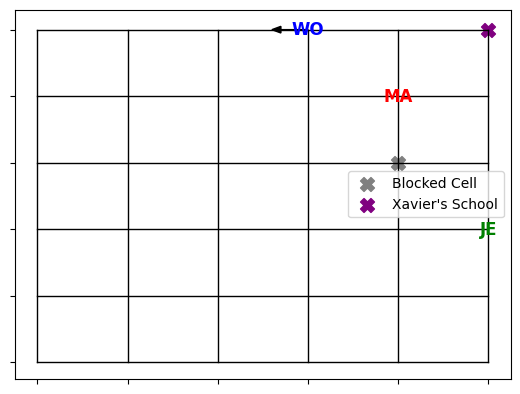



BOARD AFTER 1 MOVE(S)


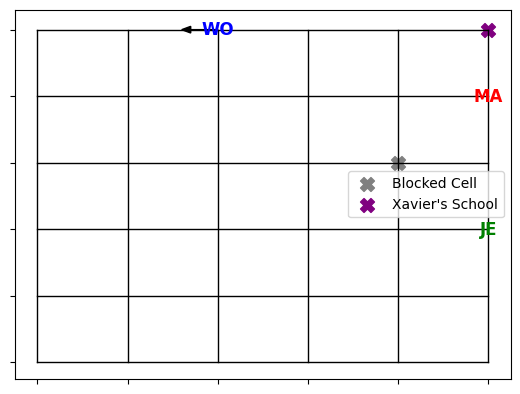



BOARD AFTER 2 MOVE(S)


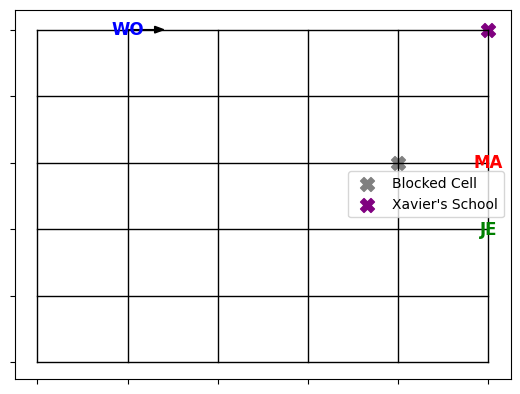



BOARD AFTER 3 MOVE(S)


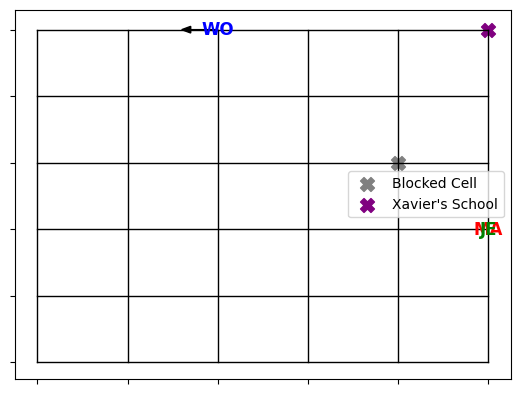



BOARD AFTER 4 MOVE(S)


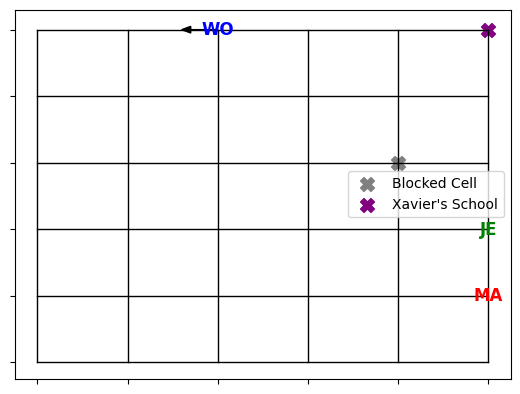



BOARD AFTER 5 MOVE(S)


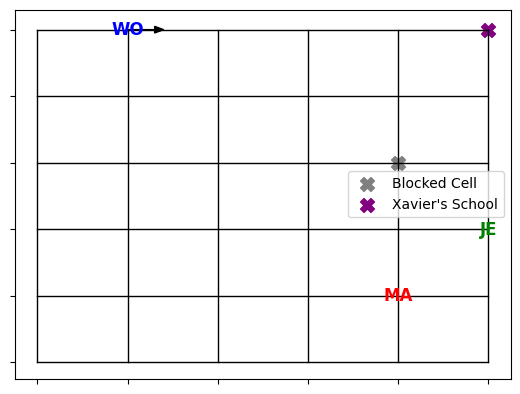



BOARD AFTER 6 MOVE(S)


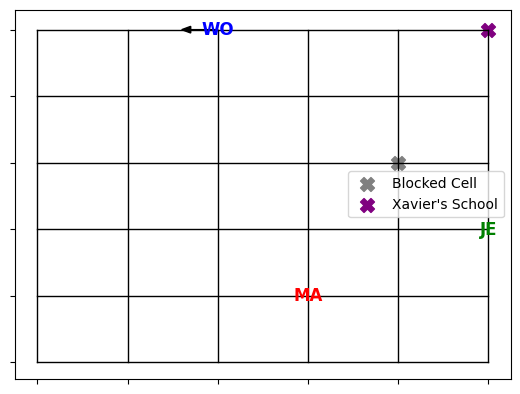



BOARD AFTER 7 MOVE(S)


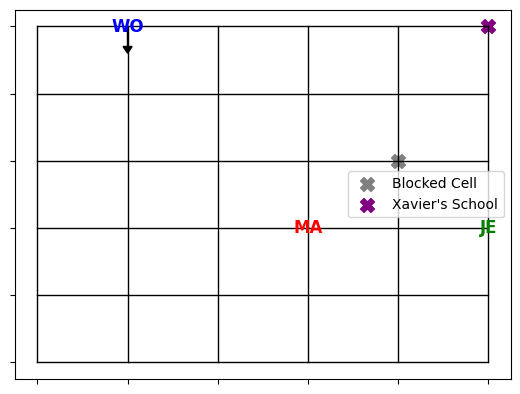



BOARD AFTER 8 MOVE(S)


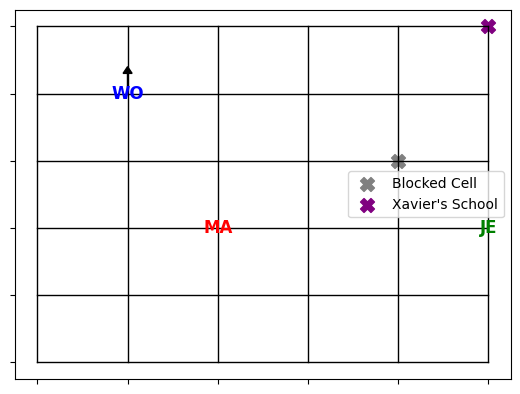



BOARD AFTER 9 MOVE(S)


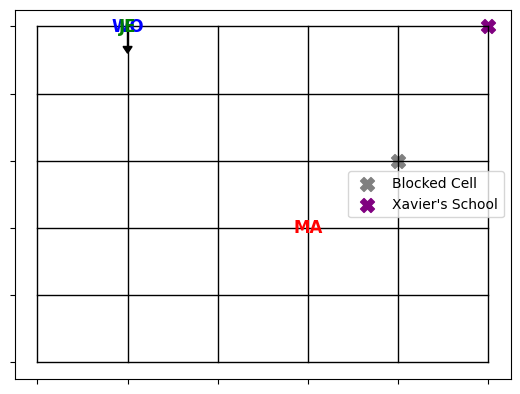


WOLVERINE IS VICTORIOUS!



ALL POLICIES


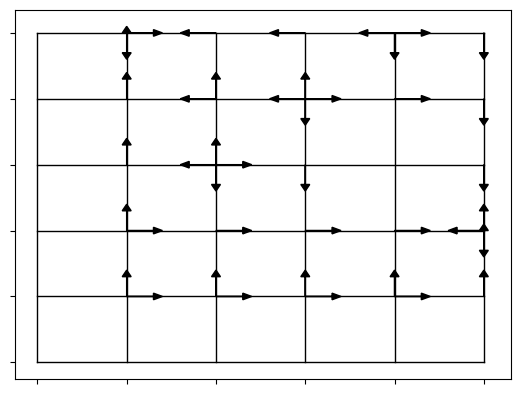

In [269]:
seed(10)
jean, magneto = Jean(jeanCells, jeanMovementProbability), LazyMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
magnetoCell = magneto.currentPosition()
wolverineCell = (3, 5)
jeanCell = jean.currentPosition()

print("INITIAL BOARD")
nextMove = mdp.nextMove(magnetoCell, wolverineCell, jeanCell)
plotGameState(magnetoCell, wolverineCell, jeanCell, gridSize, policy=nextMove)
print()

for i in range(1000000):
    if nextMove is not None and randint(1, 100) <= (movementProbability * 100):
        wolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, nextMove))
    magnetoNextCell, jeanNextCell = magneto.move(wolverineCell), jean.move()

    print(f"\nBOARD AFTER {i + 1} MOVE(S)")
    nextMove = mdp.nextMove(magnetoCell, wolverineCell, jeanCell)
    plotGameState(magnetoNextCell, wolverineCell, jeanNextCell, gridSize, policy=nextMove)
    print()

    result = getWinner(magnetoNextCell, wolverineCell, jeanNextCell)
    magnetoCell, jeanCell = magneto.currentPosition(), jean.currentPosition()
    if result is not None:
        print("MAGNETO IS VICTORIOUS!" if result == -1 else
              "DRAW!" if result == 0 else
              "WOLVERINE IS VICTORIOUS!" if result == 1 else
              "ITERATION LIMIT EXCEEDED!")
        break

print("\n\n\nALL POLICIES")
plotAllPolicies(mdp.policy, gridSize)

In [ ]:
seed(0)
mdp = MDPPolicyActive(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
mdp.policyIteration()

INITIAL BOARD


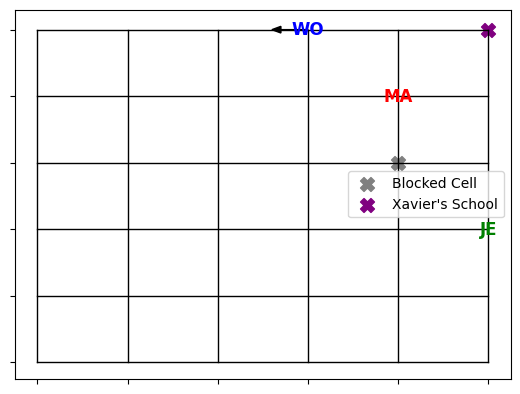



BOARD AFTER 1 MOVE(S)


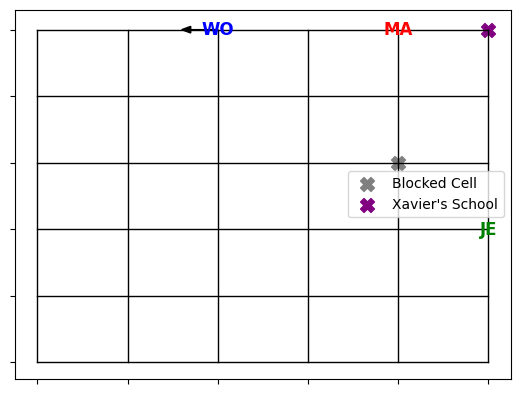



BOARD AFTER 2 MOVE(S)


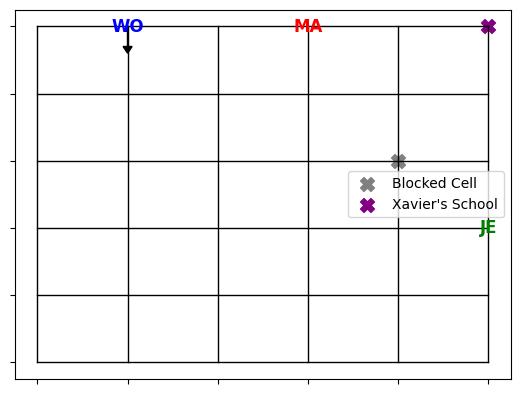



BOARD AFTER 3 MOVE(S)


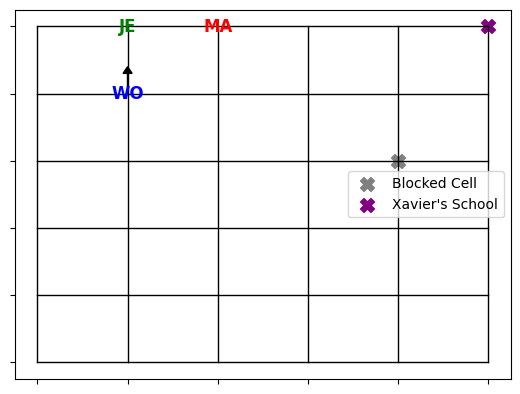



BOARD AFTER 4 MOVE(S)


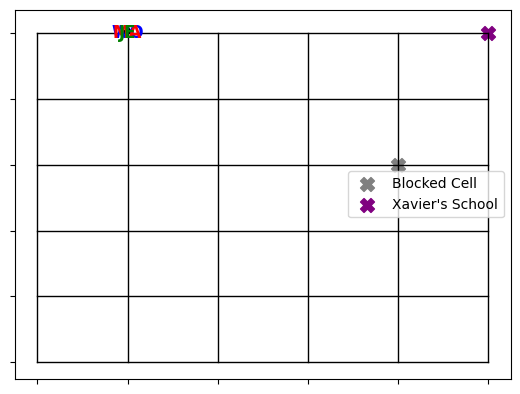


DRAW!



ALL POLICIES


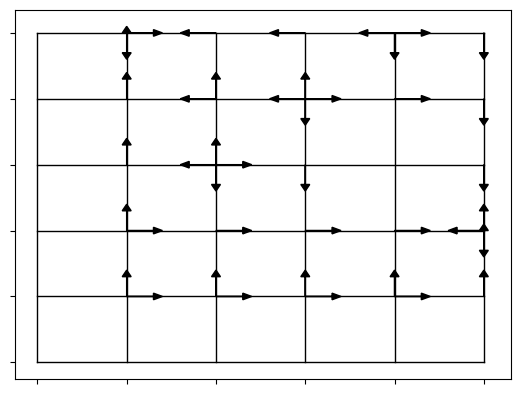

In [270]:
seed(10)
jean, magneto = Jean(jeanCells, jeanMovementProbability), ActiveMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
magnetoCell = magneto.currentPosition()
wolverineCell = (3, 5)
jeanCell = jean.currentPosition()

print("INITIAL BOARD")
nextMove = mdp.nextMove(magnetoCell, wolverineCell, jeanCell)
plotGameState(magnetoCell, wolverineCell, jeanCell, gridSize, policy=nextMove)
print()

for i in range(1000000):
    if nextMove is not None and randint(1, 100) <= (movementProbability * 100):
        wolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, nextMove))
    magnetoNextCell, jeanNextCell = magneto.move(wolverineCell), jean.move()

    print(f"\nBOARD AFTER {i + 1} MOVE(S)")
    nextMove = mdp.nextMove(magnetoCell, wolverineCell, jeanCell)
    plotGameState(magnetoNextCell, wolverineCell, jeanNextCell, gridSize, policy=nextMove)
    print()

    result = getWinner(magnetoNextCell, wolverineCell, jeanNextCell)
    magnetoCell, jeanCell = magneto.currentPosition(), jean.currentPosition()
    if result is not None:
        print("MAGNETO IS VICTORIOUS!" if result == -1 else
              "DRAW!" if result == 0 else
              "WOLVERINE IS VICTORIOUS!" if result == 1 else
              "ITERATION LIMIT EXCEEDED!")
        break

print("\n\n\nALL POLICIES")
plotAllPolicies(mdp.policy, gridSize)

In [ ]:
seed(0)
# Value Iteration for Lazy Magneto
lazyMagnetoVi = LazyMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
mdpLazyMagnetoVi = MDPValueLazy(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
startTime = time.time()
mdpLazyMagnetoVi.train()
trainingTimeLazyVi = time.time() - startTime

# Value Iteration for Active Magneto
activeMagnetoVi = ActiveMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
mdpActiveMagnetoVi = MDPValueActive(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
startTime = time.time()
mdpActiveMagnetoVi.train()
trainingTimeActiveVi = time.time() - startTime

# Policy Iteration for Lazy MagnetoLazyMagnetoPi = LazyMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
lazyMagnetoPi = LazyMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
mdpLazyMagnetoPi = MDPPolicyLazy(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
startTime = time.time()
mdpLazyMagnetoPi.policyIteration()
trainingTimeLazyPi = time.time() - startTime

# Policy Iteration for Active Magneto
activeMagnetoPi = ActiveMagneto(gridSize, moves, [blockedCell, xavierSchoolCell], movementProbability)
mdpActiveMagnetoPi = MDPPolicyActive(gridSize, moves, blockedCell, xavierSchoolCell, jeanCells, discount, movementProbability, jeanMovementProbability, 1e-1)
startTime = time.time()
mdpActiveMagnetoPi.policyIteration()
trainingTimeActivePi = time.time() - startTime

In [304]:
def playAndRecordResult(magneto, mdp):
    magnetoCell, wolverineCell, jeanCell = magneto.currentPosition(), (randint(1, gridSize), randint(1, gridSize)), jean.currentPosition()
    while not isValidWolverine(wolverineCell):
        wolverineCell = (randint(1, gridSize), randint(1, gridSize))

    result = None
    for i in range(10000):
        result = getWinner(magnetoCell, wolverineCell, jeanCell)
        if result is not None:
            break

        magnetoNextCell, jeanNextCell = magneto.move(wolverineCell), jean.move()
        result = getWinner(magnetoNextCell, wolverineCell, jeanNextCell)
        if result is not None:
            break

        nextMove = mdp.nextMove(magnetoCell, wolverineCell, jeanCell)
        if nextMove is not None and randint(1, 100) <= (movementProbability * 100):
            wolverineCell = tuple(map(lambda i, j: i + j, wolverineCell, nextMove))

    return result

def recordResults(magneto, mdp):
    results = [0] * 3
    for i in range(100000):
        result = playAndRecordResult(magneto, mdp)
        if result is not None:
            results[result + 1] += 1

    return results / np.sum(results)

In [ ]:
seed(0)
resultsDf = pd.DataFrame(index=['Lazy VI', 'Active VI', 'Lazy PI', 'Active PI'],
                           columns=['Training Time', 'Win%', 'Draw%', 'Loss%'])

resultsDf.loc['Lazy VI', 'Training Time'] = trainingTimeLazyVi
resultsDf.loc['Lazy VI', ['Loss%', 'Draw%', 'Win%']] = recordResults(lazyMagnetoVi, mdpLazyMagnetoVi) * 100

resultsDf.loc['Active VI', 'Training Time'] = trainingTimeActiveVi
resultsDf.loc['Active VI', ['Loss%', 'Draw%', 'Win%']] = recordResults(activeMagnetoVi, mdpActiveMagnetoVi) * 100

resultsDf.loc['Lazy PI', 'Training Time'] = trainingTimeLazyPi
resultsDf.loc['Lazy PI', ['Loss%', 'Draw%', 'Win%']] = recordResults(lazyMagnetoPi, mdpLazyMagnetoPi) * 100

resultsDf.loc['Active PI', 'Training Time'] = trainingTimeActivePi
resultsDf.loc['Active PI', ['Loss%', 'Draw%', 'Win%']] = recordResults(activeMagnetoPi, mdpActiveMagnetoPi) * 100

In [313]:
resultsDf

,Training Time,Win%,Draw%,Loss%
Lazy VI,0.358958,76.681,2.127,21.192
Active VI,2.519675,49.89,3.332,46.778
Lazy PI,0.389748,77.339,1.979,20.682
Active PI,10.883417,53.286,3.053,43.661


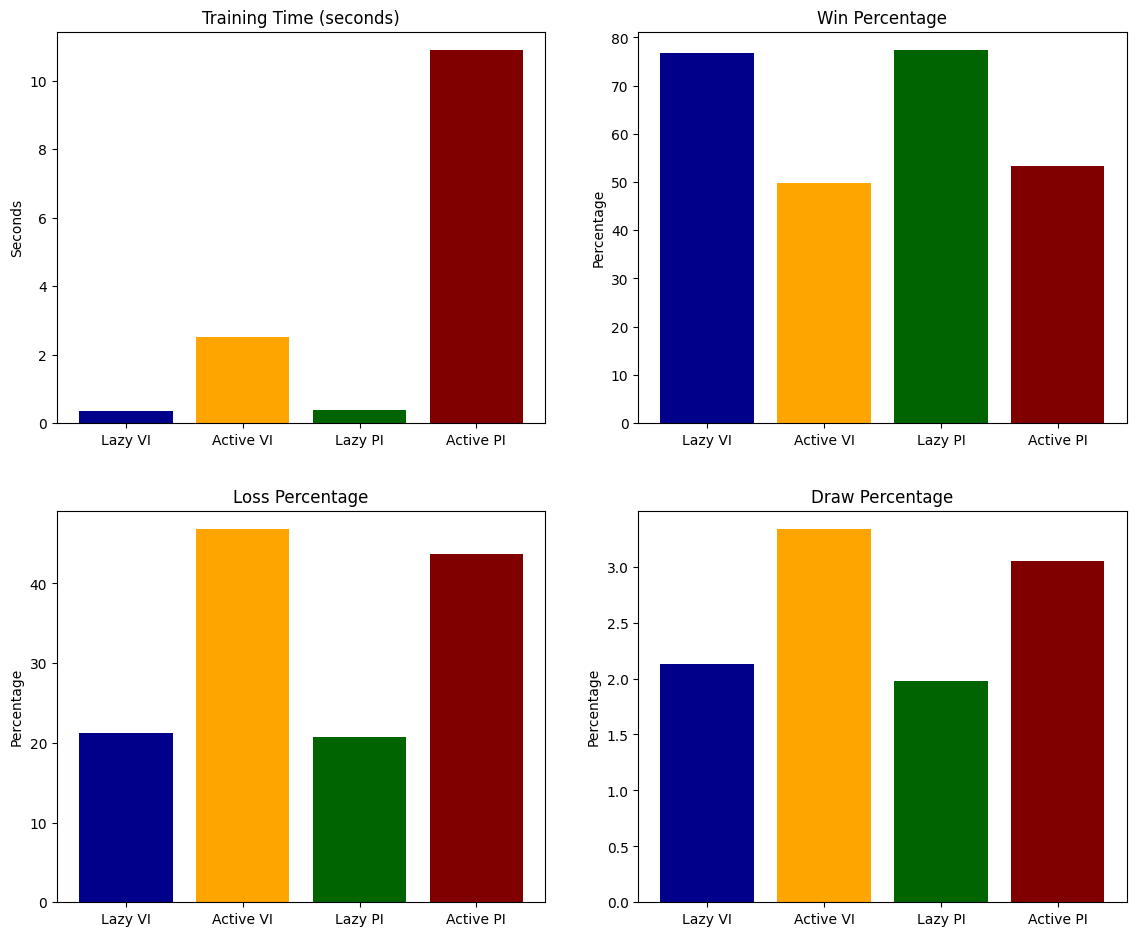

In [321]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(resultsDf.index, resultsDf['Training Time'], color=['darkblue', 'orange', 'darkgreen', 'maroon'])
axs[0, 0].set_title('Training Time (seconds)')
axs[0, 0].set_ylabel('Seconds')

axs[0, 1].bar(resultsDf.index, resultsDf['Win%'], color=['darkblue', 'orange', 'darkgreen', 'maroon'])
axs[0, 1].set_title('Win Percentage')
axs[0, 1].set_ylabel('Percentage')

axs[1, 0].bar(resultsDf.index, resultsDf['Loss%'], color=['darkblue', 'orange', 'darkgreen', 'maroon'])
axs[1, 0].set_title('Loss Percentage')
axs[1, 0].set_ylabel('Percentage')

axs[1, 1].bar(resultsDf.index, resultsDf['Draw%'], color=['darkblue', 'orange', 'darkgreen', 'maroon'])
axs[1, 1].set_title('Draw Percentage')
axs[1, 1].set_ylabel('Percentage')

plt.tight_layout(pad=3.0)
plt.show()

---
## Observations

- **Lazy VI** has the fastest training time and a high win rate.
- **Active VI** has a longer training time compared to Lazy VI. Its win rate is lower, indicating that an active Magneto is more effective in capturing Wolverine.
- **Lazy PI** has the highest win rate but with a slightly longer training time in comparison to Lazy VI.
- **Active PI** has the longest training time and a win rate lower than both Lazy VI and Lazy PI.


Considering the trade-off between training time and performance, **Lazy PI** seems to be the best approach in this context. It achieves a high win rate with relatively less training time.